# Definities

In [1]:
# Basis
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from math import floor, sqrt, pi
from statistics import mean
from glob import glob
import random
import warnings; warnings.filterwarnings('ignore')

# Geo
import geopandas as gp
from geopandas import GeoDataFrame, GeoSeries, sjoin
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import shapely.speedups; shapely.speedups.enable()

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import matplotlib.animation as animation

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Er worden verschillende coördinatenreferentiesystemen aangehouden in de gebruikte data. Er moeten ook berekeningen gedaan kunnen worden op de geometrieën (dit kan met cea en lambert). Tot slot kiezen we voor een Amersfoortprojectie voor de kaarten, maar Mercator levert ongeveer hetzelfde eindresultaat. 

In [2]:
# Definieer projecties
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area
# mercator = {'init': 'epsg:3395'}     # Mercatorprojectie
# lambert = {'init': 'epsg:3035'}      # Lambert Azimuthal Equal Area projection

Definieer bomen

In [87]:
# Oppervlaktes van bomen (m²)
kleine_boom = 10.5
middel_boom = 14.3
grote_boom = 18.7

# Oppervlakte van een microbosje (4 bomen)
tiny_forest_area = grote_boom * 4  # 280  # m²

# Type bomen, gebaseerd op boomhoogte
lage_bomen = ['tot 6 m', '6-9 m', '9-12 m', 'Onbekend']
midd_bomen = ['12-15 m', '15-18 m']
hoge_bomen = ['18-24 m', '24 m en hoger']

# Minimale afstand voor nieuwe bomen
min_dist = .5  # m

Definieer een aantal functies die voor ons GeoDataFrames maken en willekeurig nieuwe bomen planten.

In [103]:

def to_crs(gdf, crs_out=amersfoort):
    '''Returns a GeoDataFrame with coordinates projected as specified (default epsg:28992)'''
    gdf = gdf.to_crs(crs_out)  # Use geopandas built-in method
    gdf.crs = crs_out  # Set CRS property as well, just to be sure
    return gdf


def create_gdf(df, crs_in=crs, crs_out=amersfoort):
    '''Accepts a DataFrame with a specified CRS (default epsg:4326), 
    and returns a re-projected GeoDataFrame (default epsg:28992)'''
    
    # Transform Point geometries that are in the wrong format 
    if any(df.geometry.str.contains('POINT')):
        df['geometry'] = df.geometry.str.replace(',', ' ')
    
    # Transform geometry from text, create GeoDataFrame, and re-project to crs_out
    gdf = GeoDataFrame(df, crs=crs_in, geometry=df.geometry.apply(wkt.loads))
    return to_crs(gdf, crs_out)


def import_csv(csv, crs_in=crs, crs_out=amersfoort):
    '''Accepts a csv file and returns a GeoDataFrame'''
    df = pd.read_csv(csv, dtype=str, sep=';').drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT'])
    df = df[df.columns.drop(df.filter(regex='Unnamed').columns)].rename(columns={'WKT_LNG_LAT':'geometry'})
    return create_gdf(df, crs_in, crs_out)


def calc_area(gdf, m=False, crs_out=amersfoort):
    '''Adds a new column to a GeoDataFrame that contains the surface area in km² (or m² if m=True) of its geometries'''
    gdf = to_crs(gdf, cea)  # Use equal areas to make area calculations
    if not m:
        m = 10**6  # Re-calculate to km²
    gdf['oppervlakte'] = gdf.geometry.area / m
    return to_crs(gdf, crs_out)

def explode_into(gdf, crs_io=amersfoort):
    '''Explodes MultiPolygons within a GeoDataFrame and returns it.'''
    gdf = gdf.set_index('gml_id')
    tmp = gdf[gdf.geometry.astype(str).str.contains('MULTIPOLYGON')].copy()
    tmp1 = gdf[~gdf.geometry.astype(str).str.contains('MULTIPOLYGON')].copy()
    tmp_geometry = GeoDataFrame(tmp.geometry.explode()).reset_index(level=[0, 1])
    tmp = tmp.drop(columns='geometry')
    tmp2 = tmp_geometry.merge(tmp, how='outer', on='gml_id')
    tmp2['gml_id'] = tmp2[['gml_id', 'level_1']].apply(lambda x: '-'.join(x.astype(str)), axis=1)
    tmp2 = tmp2.drop(columns='level_1')
    gdf = GeoDataFrame(pd.concat([tmp1, tmp2]), crs=crs_io, geometry='geometry')
    return gdf


def random_points_within(poly, k, min_dist=min_dist):
    
    '''Returns a list of lists of k random Point objects that are within poly, seperated by at least min_dist'''
    
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i = 0
    
    while len(points) < k:
        
        i += 1
        
        # Pak een random punt op de x-as, en vind en een random punt op de y-as dat in het polygoon ligt
        try:
            x = random.uniform(min_x, max_x)
            x_line = LineString([(x, min_y), (x, max_y)])
            x_line_intercept_min, x_line_intercept_max = x_line.intersection(poly).xy[1].tolist()
            y = random.uniform(x_line_intercept_min, x_line_intercept_max)
        except:
            continue
        
        point = Point([x, y])
        
        # Controleer of de afstand van een nieuwe boom tot bestaande bomen kleiner is dan min_dist
        # (Dit werkt nog niet goed wanneer min_dist te groot is)
        dist = []
        gdf = GeoDataFrame(points, crs=cea)
        for ind in range(len(gdf)):
            dist.append(gdf.iat[ind, 0].distance(point) < min_dist)  # bool
        
        # Voeg de nieuwe boom toe, behalve als er een andere nieuwe boom dichterbij ligt dan min_dist
        if sum(dist) == 0:# and poly.exterior.distance(point) < gem_afstand_tot_rand:
            points.append(point)
        elif i > k * 2:
            print(f'It was impossible to find enough points within poly with id:')
            return points
        else:
            continue
        
    return points


def random_points(row, colname='nieuwe_bomen', min_dist=.5):
    
    '''Returns a list of lists of random points, 
    based on a geometry and a value of nieuwe_bomen in a GeoDataFrame'''
    
    points = random_points_within(row['geometry'], row[colname], min_dist=min_dist)
    
    if len(points) < row[colname]:
        print(f'{row.name}\n')
    
    return points


def plant_trees(gdf, colname='nieuwe_bomen', min_dist=.5):
    
    '''Returns a GeoSeries (with epsg:28992) of random points within each geometry of a GeoDataFrame'''
    
    # change gdf.crs to cea for equal area calculations 
    gdf = to_crs(gdf, cea)
    
    # get a list of lists of random points within gdf.geometry:
    points = gdf.apply(random_points, colname=colname, min_dist=min_dist, axis=1)
    
    # transform into a Series
    points = pd.Series(points).apply(lambda x: pd.Series(x)).stack().tolist()
    
    # transform into a GeoSeries
    geo = GeoSeries(points, crs=cea)
    
    # change crs to epsg:28992
    geo = to_crs(geo, amersfoort)
    
    return geo



# Gebieden

We importeren hier .csv-bestanden (epsg:4326) van de Gemeente Amsterdam (https://maps.amsterdam.nl/open_geodata/?LANG=nl).

In [5]:
# Importeer stadsdelen
sd = import_csv('data/020/GEBIED_STADSDELEN.csv')#_EXWATER.csv')
sd = calc_area(sd)  # Voeg een kolom toe met oppervlakte per stadsdeel

# Importeer buurten
buurten = import_csv('data/020/GEBIED_BUURTEN.csv').rename(index=str, columns={'Buurt_code': 'Buurtcode'})

# We laten de buurt Waterland en grote delen van Westpoort buiten beschouwing
buurten = buurten[buurten.Buurtcombinatie_code != 'N73']
buurten = buurten[~buurten.Buurtcode.isin(['B10a', 'B10c', 'B10d', 'B10e', 'B10f', 'B10g', 'B10h'])]
buurten = buurten.merge(sd[['Stadsdeel_code', 'Stadsdeel']], on='Stadsdeel_code', how='left')

# Bomen

We importeren hier .csv-bestanden (espg:4326) van de Gemeente Amsterdam (https://maps.amsterdam.nl/open_geodata/?k=254).

In [82]:
# Importeren en samenvoegen van de vier .csv-bestanden
bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['Soortnaam_NL', 'Boomnummer', 'Boomtype', 'Boomhoogte', 'WKT_LNG_LAT']) 
                   for file in glob('data\BOMEN*.csv')], axis=0, ignore_index=True).rename(columns={'WKT_LNG_LAT':'geometry'})

# Elke boom heeft een aantal van 1, dit gebruiken we later
bomen['aantal_bomen'] = 1

# Kolom toevoegen met boomoppervlakte (in m²) op basis van de boomhoogte
bomen['boomoppervlakte'] = np.where(bomen['Boomhoogte'].isin(lage_bomen), kleine_boom, 
                                    np.where(bomen['Boomhoogte'].isin(hoge_bomen), grote_boom, middel_boom))
bomen['radius'] = np.sqrt(bomen.boomoppervlakte.values / pi)

# Maak van bomen een fatsoenlijk GeoDataFrame
bomen = create_gdf(bomen)  # crs=amersfoort, zie functie hierboven

# Voeg Polygons toe, deze worden later gebruikt voor ruimteberekeningen
# bomen['polygons'] = GeoSeries(bomen.apply(lambda x: x.geometry.buffer(.5), axis=1), crs=amersfoort)
bomen['polygons'] = GeoSeries(bomen.apply(lambda x: x.geometry.buffer(x.radius), axis=1), crs=amersfoort)

# Wegen

We importeren hier .GeoJson-bestanden (epsg:28992), die met behulp van QGIS zijn omgezet vanuit .gml-bestanden uit de BGT (https://www.pdok.nl/downloads/-/article/basisregistratie-grootschalige-topografie-bgt-). 

In [7]:
# Importeren van bermen
gdf_berm = gp.read_file('C:/Users/PSaalbrink/Desktop/BGT/GeoJSON/bgt_ondersteunendwegdeel AuxiliaryTrafficArea.GeoJSON')[[
    'gml_id', 'creationDate', 'function', 'surfaceMaterial', 'plus-fysiekVoorkomenOndersteunendWegdeel', 'geometry'
]].rename(columns={'plus-fysiekVoorkomenOndersteunendWegdeel':'fysiekVoorkomenWegdeel'})  # crs=amersfoort

In [8]:
# Importeren van wegen
gdf_weg = gp.read_file('C:/Users/PSaalbrink/Desktop/BGT/GeoJSON/bgt_wegdeel TrafficArea.GeoJSON')  # crs=amersfoort

# Kolommen ordenen 
gdf_weg = gdf_weg[[
    'gml_id', 'creationDate', 'function', 'surfaceMaterial', 'plus-fysiekVoorkomenWegdeel', 'plus-functieWegdeel', 'geometry'
]].rename(columns={'plus-fysiekVoorkomenWegdeel': 'fysiekVoorkomenWegdeel', 'plus-functieWegdeel': 'functieWegdeel'})

Maak een GeoDataFrame

In [83]:
# Samenvoegen van bermen en wegen tot één dataset
gdf = GeoDataFrame(pd.concat([gdf_weg, gdf_berm], ignore_index=True), crs=amersfoort)
# gdf = gdf.sample(10000, random_state=42)
gdf = gdf.where(~gdf.isna(), 'waardeOnbekend')  # NaN vervangen door waardeOnbekend (niet noodzakelijk, wel consistent)
gdf = gdf.set_index('gml_id')  # Indexeren op gml_id

# Kolom met oppervlakte per wegdeel toevoegen
gdf = calc_area(gdf, m=True)  # zie functie hierboven

# Sommige geometrieën zijn LineStrings, deze verwijderen we
gdf = gdf[gdf.oppervlakte != 0]

# De kolom functieWegdeel voegt maar één waarde toe, deze nemen we mee in de kolom function
gdf['function'] = gdf.function.where(gdf.functieWegdeel != 'verkeersdrempel', 'verkeersdrempel')
gdf = gdf.drop(columns=['functieWegdeel'])

We willen onderscheid maken op buurtniveau. Daarom splitsen we de wegdelen op per buurt:

In [84]:
# Informatie over buurten toevoegen aan ons gdf, om te gebruiken voor het plotten
# Dit doen we met overlay, waarbij wegdelen die in meerdere buurten liggen doormidden worden geknipt

# gml_id toevoegen als kolom
gdf = gdf.reset_index().rename(columns={'index': 'gml_id'})

# Intersecties maken met buurten
gdf = gp.overlay(gdf, buurten, how='intersection')

# # MultiPolygons vervangen
# gdf = explode_into(gdf)

# Bereken opnieuw de oppervlaktes van de wegdelen (nu dus per buurt)
gdf = calc_area(gdf.rename(columns={'oppervlakte': 'oorspr_opp_wegdeel'}), m=True)

# Indexeren op gml_id
gdf = gdf.set_index('gml_id')

# Waar op wegdelen staan bomen?

In [89]:
# We gaan hieronder een aantal kolommen toevoegen.
# Allereerst moeten we vinden welke bomen op welke wegdelen staan:
sjoined = sjoin(gdf, bomen, how='left')  # Deze bewaren we voor later

In [90]:
# Kolom toevoegen voor afstand van een boom tot de rand van een polygon.
# Hiervoor maken we een tijdelijk GeoDataFrame met daarin de bestaande bomen
tmp = to_crs(bomen.copy(), cea)  # Gebruik cea voor het rekenen met equal area

# Kopieër de geometrieën, zodat we zometeen de geometrie van bomen kunnen behouden naast de geometrie van wegdelen
tmp['punten'] = tmp.geometry.astype(str).copy()

# Maak opnieuw een spatial join, maar bewaar alleen de wegdelen waarop bomen staan
tmp = sjoin(to_crs(gdf.copy(), cea), tmp, how='inner')

In [93]:
# Maak een GeoSeries met de afstand van een boom-punt tot de rand van een wegdeel.
# We moeten hier opnieuw de geometrie inladen, omdat we deze hierboven hadden omgezet in tekst
# tmp = tmp.geometry.exterior.distance(GeoDataFrame(tmp.punten, geometry=tmp.punten.apply(wkt.loads), crs=cea))
# tmp.name = 'gem_afstand_tot_rand'
tmp['gem_afstand_tot_rand'] = 1.5
tmp = tmp.gem_afstand_tot_rand
tmp = tmp.groupby(tmp.index).mean()  # Groepeer op gml_id van wegdeel, en neem het gemiddelde van gem_afstand_tot_rand

# Voeg gem_afstand_tot_rand toe aan de eerder gemaakte spatial join. Er wordt samengevoegd adhv gml_id van wegdeel
joined = sjoined.join(tmp, how='left')

In [94]:
# Kolom toevoegen aan ons GeoDataFrame voor het aantal bomen per wegdeel-polygoon
gdf = gdf.merge(joined  # Dit zijn de wegdelen plus de nieuwe kolom gem_afstand_tot_rand
                .groupby(joined.index).sum()[[  # Groepeer op gml_id van wegdeel, en neem de som van
                    'aantal_bomen', 'boomoppervlakte', 'gem_afstand_tot_rand']],  # deze kolommen
                how='left', left_index=True, right_index=True)  # Voeg samen op gml_id en behoud alle wegdelen

# Opschonen
del tmp, joined, sjoined

In [95]:
# Zet aantal_bomen om van float naar int
gdf['aantal_bomen'] = gdf.aantal_bomen.astype(int)

# Dit was eerst al een gemiddelde, maar omdat we hierboven aggregeerden met som, 
# moeten we opnieuw delen door het aantal om weer op het gemiddelde uit te komen
gdf['gem_afstand_tot_rand'] = gdf.gem_afstand_tot_rand / gdf.aantal_bomen

In [96]:
# Tabel maken om te bekijken hoeveel bomen er op welke wegdelen staan

# Percentage bomen indien er al bomen op de wegdelen staan
bomen_per_functie = gdf[gdf.aantal_bomen > 0]
bomen_per_functie = bomen_per_functie[['function', 'aantal_bomen', 'oppervlakte', 'boomoppervlakte']].groupby(
    ['function'], as_index=False).sum()
bomen_per_functie = bomen_per_functie.set_index('function')
percentage_if_bomen = (bomen_per_functie.boomoppervlakte / bomen_per_functie.oppervlakte)
percentage_if_bomen.name = 'percentage_if_bomen'

# Percentage bomen op alle wegdelen
bomen_per_functie = gdf[['function', 'aantal_bomen', 'oppervlakte', 'boomoppervlakte']].groupby(
    ['function'], as_index=False).sum()
bomen_per_functie = bomen_per_functie.set_index('function')
bomen_per_functie = bomen_per_functie.merge(percentage_if_bomen, how='left', left_index=True, right_index=True)
bomen_per_functie['percentage_totaal_bomen'] = (bomen_per_functie.boomoppervlakte / bomen_per_functie.oppervlakte)

# Informatie toevoegen aan ons GeoDataFrame
gdf = gdf.merge(percentage_if_bomen, how='left', left_on='function', right_index=True)

# bomen_per_functie.sort_values('percentage_if_bomen', ascending=False).to_csv('bomen_per_functie.csv')

In [97]:
# Hoeveel bestaande bomen staan er niet op wegdelen? 
org = bomen.aantal_bomen.sum()
clc = gdf.aantal_bomen.sum()
print(f'Er zijn {org} - {clc} = {org - clc} bomen die niet op wegdelen staan,\n'
      f'deze worden in de verdere analyse dus buiten beschouwing gelaten.')
del org, clc

Er zijn 265036 - 10556 = 254480 bomen die niet op wegdelen staan,
deze worden in de verdere analyse dus buiten beschouwing gelaten.


# Ruimte vinden voor nieuwe bomen

Kolommen toevoegen voor (ruimte voor) nieuwe bomen 

In [98]:
# Informatie over bomen toevoegen aan ons gdf, om te gebruiken voor berekeningen
# Dit doen we met overlay, waarbij de oppervlakte van bomen van de wegdelen af wordt gehaald

# gml_id toevoegen als kolom
gdf = gdf.reset_index().rename(columns={'index': 'gml_id'})

# Bestaande bomen van de polygonen aftrekken (deze tellen niet mee als beschikbare ruimte)
gdf = gp.overlay(gdf, GeoDataFrame(bomen.polygons, crs=amersfoort, geometry='polygons'), how='difference')

# # MultiPolygons naar Polygons
# gdf = explode_into(gdf)

# Bereken opnieuw de oppervlaktes van de wegdelen (per buurt, en rekening houdend met bestaande bomen)
gdf = calc_area(gdf.rename(columns={'oppervlakte': 'oorspr_opp_wegdeel_buurt'}), m=True)

# Indexeren op gml_id
gdf = gdf.set_index('gml_id')

In [99]:
# Vervolgens filteren we ons GeoDataFrame:
tmp = gdf[(gdf.aantal_bomen > 0) |    # op stukken waar al andere bomen staan;
          ((gdf.aantal_bomen == 0) &  # op terrein waar nog geen bomen staan, 
           (gdf.function.isin([       # en dat een van de volgende functies heeft:
               'berm', 
               'inrit', 
               'parkeervlak', 
               'transitie', 
               'verkeersdrempel', 
               'verkeerseiland', 
               'voetgangersgebied', 
               'voetpad', 
               'voetpad op trap', 
               'woonerf', 
           ])))]

In [100]:
# Reken met het percentage in gebruik het percentage bij te planten bomen uit
# en bereken daarmee de ruimte voor bomen (in m²) per wegdeel
tmp['ruimte'] = tmp.oppervlakte * (
    (tmp.percentage_if_bomen - ((tmp.oorspr_opp_wegdeel_buurt - tmp.oppervlakte) / tmp.oorspr_opp_wegdeel_buurt)))
tmp.loc[tmp.ruimte < 0, 'ruimte'] = 0  # Beschikbare ruimte kan niet negatief zijn

In [101]:
# Aantal voor nieuwe bomen toevoegen, aan de hand van de beschikbare ruimte.
# Hierbij wordt ervan uitgegaan dat de beschikbare ruimte helemaal vol wordt geplant
# en dat een boom de ruimte inneemt van een vierde van een microbosje
tmp['nieuwe_bomen'] = (tmp.ruimte / (tiny_forest_area / 4))

# We kunnen ook uitrekenen welke grootte de bomen die we planten kunnen hebben
# Dit kan gebruikt worden voor een meer nauwkeurige berekening
# Zie rapport voor de effecten van verschillende typen bomen
tmp['grote_bomen']  = (tmp.ruimte / grote_boom)
tmp['middel_bomen'] = np.where((tmp.ruimte % grote_boom) > middel_boom, 1, 0)
tmp['kleine_bomen'] = np.where(np.logical_and((tmp.ruimte % grote_boom) > kleine_boom, 
                                              (tmp.ruimte % grote_boom) < middel_boom), 1, 0)

# Tot slot de nieuwe kolommen toevoegen met ons GeoDataFrame
gdf = gdf.join(tmp[['ruimte', 'nieuwe_bomen', 'grote_bomen', 'middel_bomen', 'kleine_bomen']], how='left')

del tmp

In [102]:
# Hoeveel bomen kunnen we planten? 
groot = gdf.grote_bomen.sum().astype(int)
middel = gdf.middel_bomen.sum().astype(int)
klein = gdf.kleine_bomen.sum().astype(int)
print(
    f'Er kunnen {(gdf.nieuwe_bomen.sum() / 4).astype(int):,} microbosjes geplant worden in Amsterdam.\n'
#       f'Deze kunnen bestaan uit {groot:,} grote, {middel:,} middel, en {klein:,} kleine bomen.'
)

Er kunnen 4,683 microbosjes geplant worden in Amsterdam.



# Bomen planten

Maak data om te plotten

In [104]:
gs_nieuwe_bomen = plant_trees(gdf)
# gs_nieuwe_bomen.to_csv('gs_nieuwe_bomen.csv')

It was impossible to find enough points within poly with id:
b1179b7b6-a290-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b1179dec8-a290-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b1179dec8-a290-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b117a05e1-a290-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b117a05e3-a290-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b1e184ff0-de4c-11e7-8ec4-89be260623ee

It was impossible to find enough points within poly with id:
b24221b5a-575d-11e8-a5a2-73a1868acdce

It was impossible to find enough points within poly with id:
b36650dfd-a291-11e8-80ae-53ebeb2ba6e0

It was impossible to find enough points within poly with id:
b3665350e-a291-11e8-80ae-53ebeb2ba6e0

It was impossible to find enough points within poly with id:
b36661f85-a291-11e8-80ae-53ebeb2ba6e0



In [105]:
bomen = bomen[bomen.geometry.within(sd.geometry[0])]

In [ ]:
# Maak subset van de wegen-data
tmp = gdf[gdf.Buurt.isin(['Alfa-driehoek', 'Bedrijventerrein Sloterdijk I'])]

# Maak een GeoSeries met nieuwe bomen
geo = plant_trees(tmp, min_dist=.6)

# Maak subset van bestaande bomen
boom = bomen[bomen.geometry.within(buurten[buurten.Buurt.isin(['Alfa-driehoek', 'Bedrijventerrein Sloterdijk I'])].geometry[0])]

# Pak de locatie van Matrixian
mx = GeoSeries(Point([118284, 489564]), crs=amersfoort)

# Waar planten we de bomen?

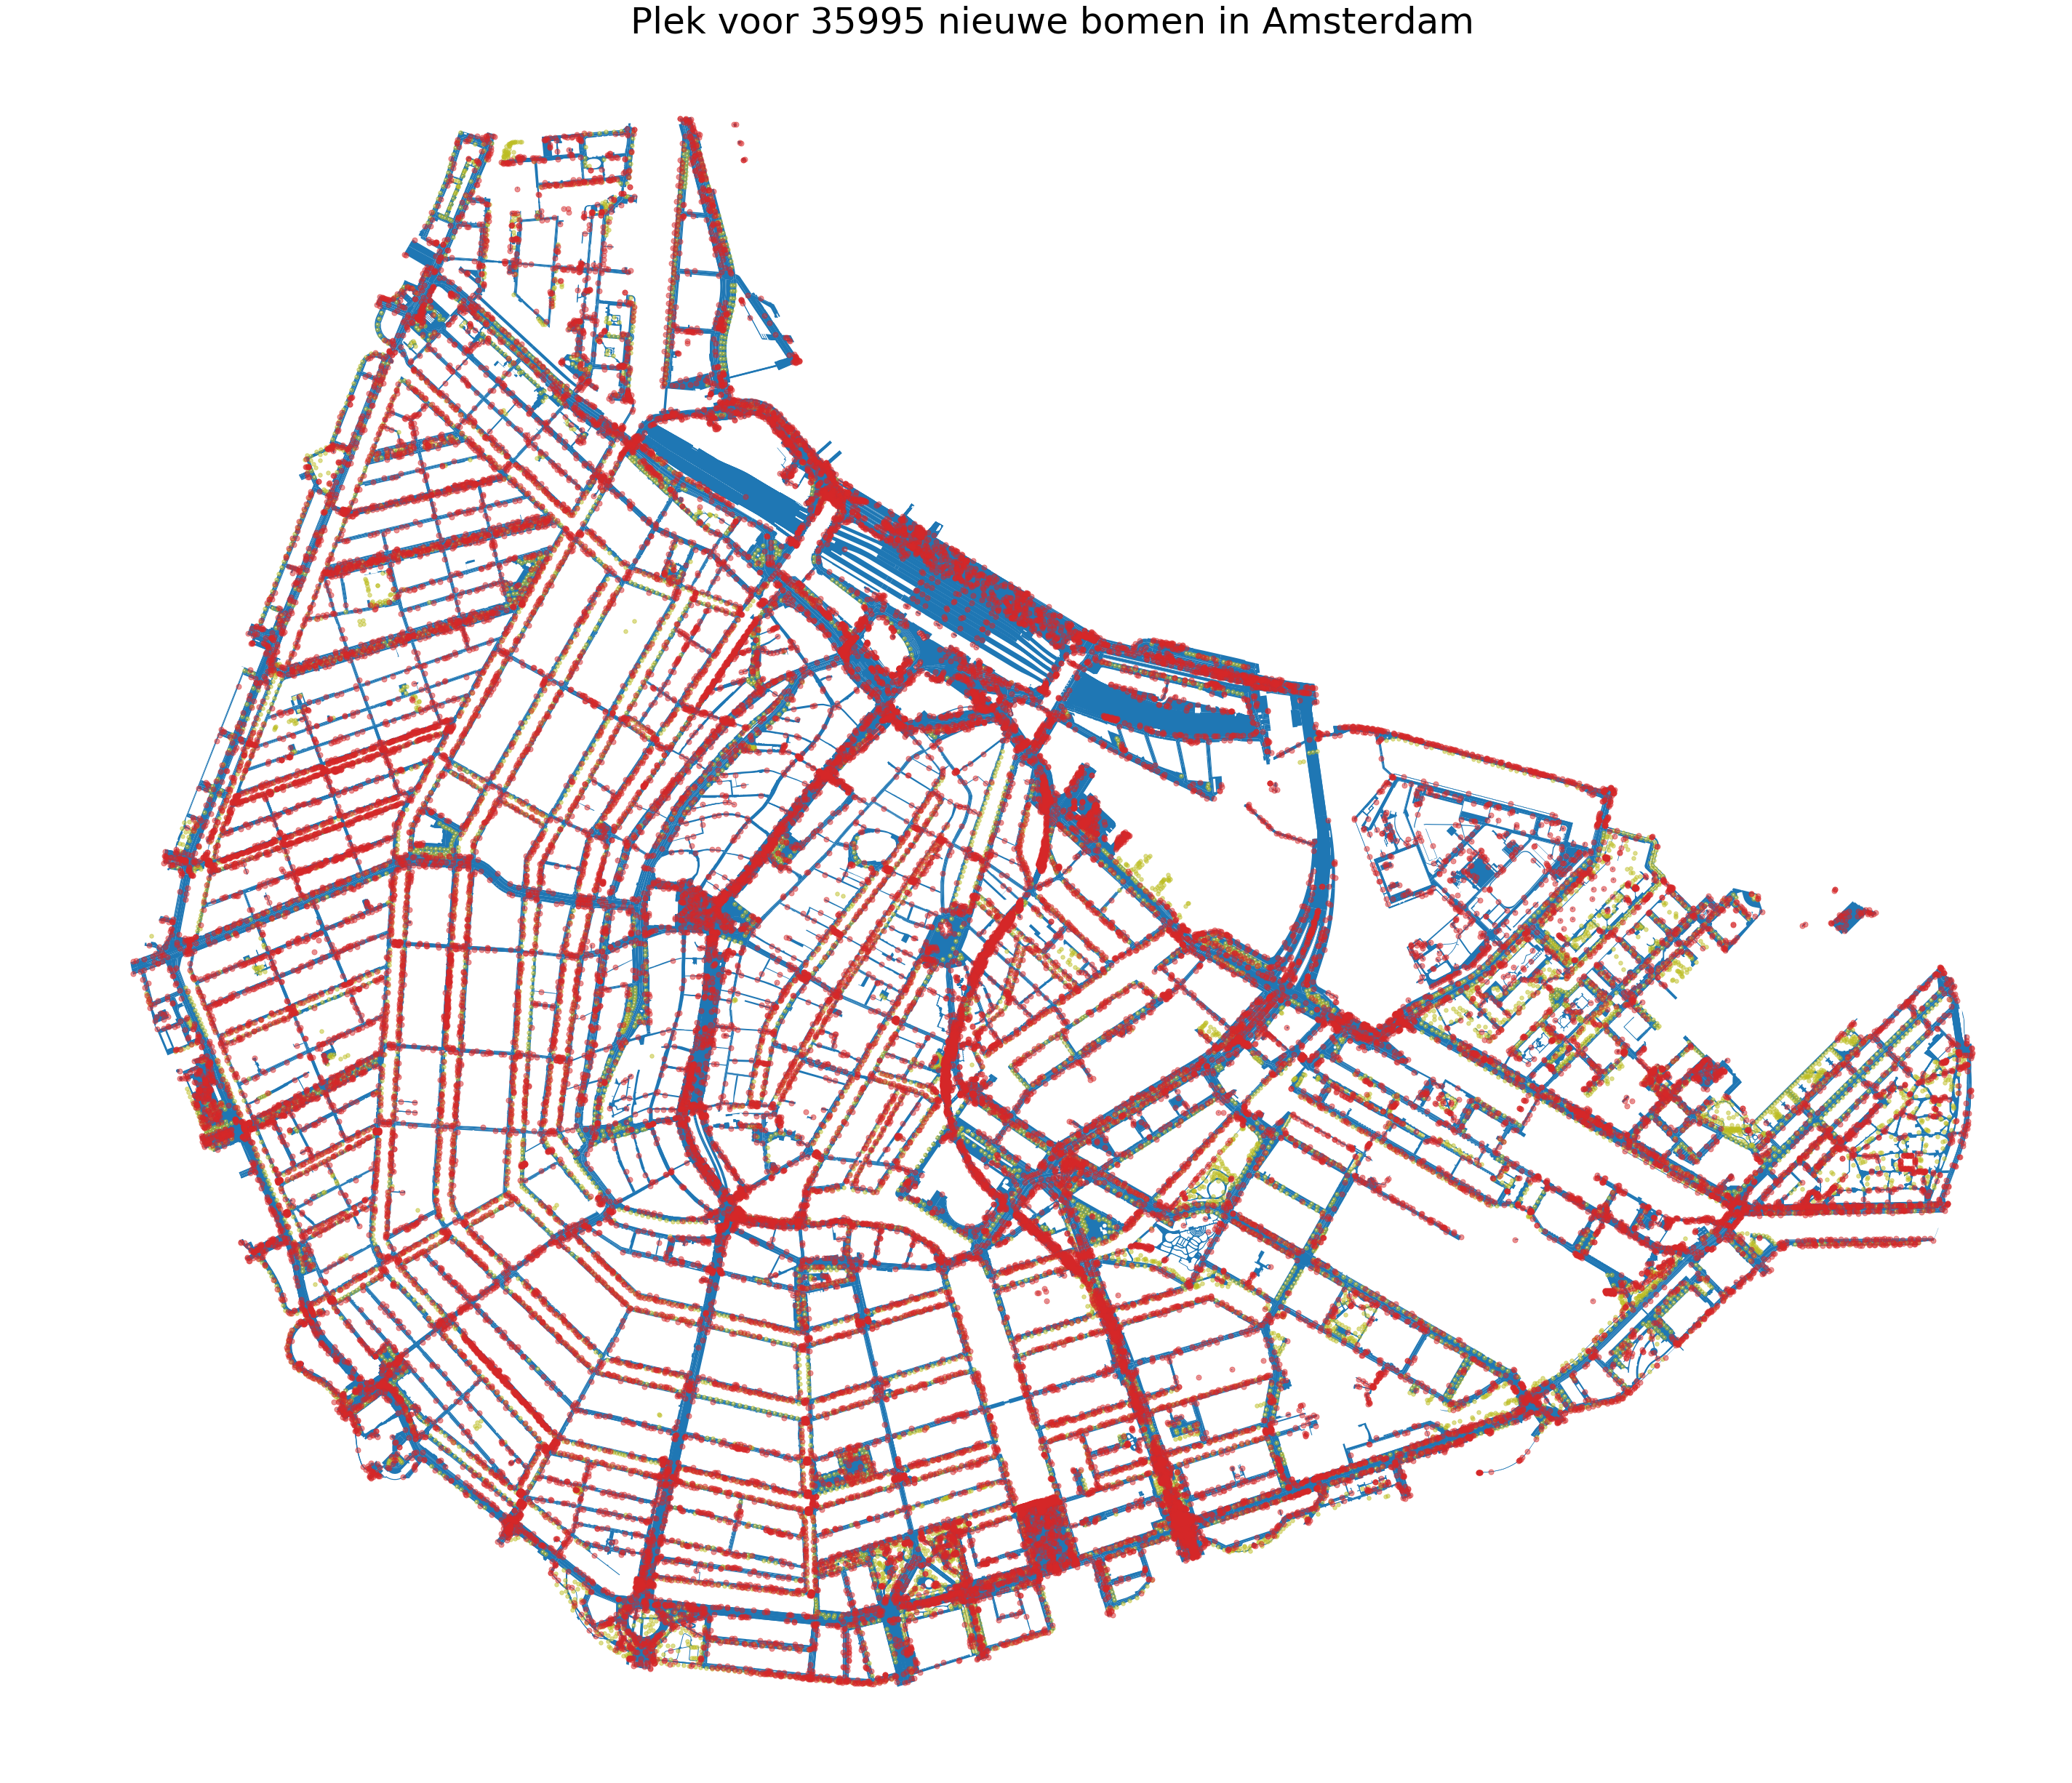

In [106]:
# Plot heel Amsterdam

fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
plt.title(f'Plek voor {len(gs_nieuwe_bomen)} nieuwe bomen in Amsterdam', size=50)
gdf.plot(ax=ax, color='#1f77b4')
bomen.plot(ax=ax, color='#bcbd22', markersize=30, alpha=.5)
gs_nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=50, alpha=.5)
plt.savefig('Amsterdam_nwe_bomen.png')

Maak een plot van de omgeving van Matrixian

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
plt.title(f'{len(geo)} nieuwe bomen rondom het kantoor van Matrixian Group', size=50)

# Plot de wegen
tmp.plot(ax=ax, color='#1f77b4')

# Plot de bestaande bomen
boom.plot(ax=ax, color='#bcbd22')

# Plot de nieuwe bomen
geo.plot(ax=ax, color='#d62728', markersize=50)

# Plot de locatie van Matrixian
mx.plot(ax=ax, color='k', markersize=400, marker='X')
plt.annotate(s='Matrixian', xy=(118434, 489564), horizontalalignment='center', size=40, 
             bbox=dict(facecolor='mediumaquamarine', edgecolor='mediumvioletred', boxstyle=f'round,pad=0.1'));

# del geo, tmp

plt.savefig('MX.png')

Maak ook nog een plot voor stadsdeel Centrum (dit duurt eventjes)

In [ ]:
geo_weg = GeoDataFrame(gdf.geometry.copy(), crs=amersfoort)
geo_weg = geo_weg[geo_weg.geometry.within(sd.geometry[0])]
geo_bomen = bomen[bomen.geometry.within(sd.geometry[0])]
nieuwe_bomen = plant_trees(gdf[gdf.geometry.within(sd.geometry[0])])

In [ ]:
fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
plt.title(f'{len(nieuwe_bomen)} nieuwe bomen in stadsdeel Centrum', size=50)
geo_weg.plot(ax=ax, color='#1f77b4')
geo_bomen.plot(ax=ax, color='#bcbd22', markersize=50)
nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=50, alpha=.5)
plt.savefig('Centrum_nwe_bomen.png')